In [1]:
import torch
import torch.nn as nn
import sys
sys.path.append('../utils')
from utils import get_num_model_params
import matplotlib.pyplot as plt

In [2]:

class CnnBaseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = self.create_conv_blocks(1, 32)
        self.conv2 = self.create_conv_blocks(32, 32)
        self.conv3 = self.create_conv_blocks(32, 64, stride=1)
        self.conv4 = self.create_conv_blocks(64, 64)
        
        self.avg_pool = nn.AvgPool2d(3)
        self.fc = nn.Linear(64, 10)
        print("CnnBaseModel created")
        
    def create_conv_blocks(self, in_c, out_c, stride=2):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, stride=stride, bias=False),
            nn.ReLU(),
            nn.Dropout(0.1),
            # nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, stride=2, bias=False),
            # nn.ReLU()
        )
        
    def forward(self, x):
        # x: bs, 1, 28, 28
        x = self.conv1(x) # bs, 16, 14, 14
        x = self.conv2(x) # bs, 32, 7, 7
        x = self.conv3(x) # bs, 64, 7, 7
        x = self.conv4(x) # bs, 64, 3, 3
        x = self.avg_pool(x) # bs, 64, 1, 1
        x = x.view(-1, x.size(1)) # bs, 64
        x = self.fc(x)
        return x
    

In [3]:
model = CnnBaseModel()
# model.fc = nn.Identity()
model

CnnBaseModel created


CnnBaseModel(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )
  (avg_pool): AvgPool2d(kernel_size=3, stride=3, padding=0)
  (fc): Linear(in_features=64, out_features=10, bias=True)
)

In [6]:
get_num_model_params(model)

'64,800'

In [20]:
model.conv1[0].weight.data = torch.zeros(32, 1, 3, 3)

In [6]:
for name, param in model.named_parameters():
    param = torch.rand_like(param)
    print(name, param.shape, param.view(-1, 3, 3).shape)

conv1.0.weight torch.Size([32, 1, 3, 3]) torch.Size([32, 3, 3])
conv2.0.weight torch.Size([32, 32, 3, 3]) torch.Size([1024, 3, 3])
conv3.0.weight torch.Size([64, 32, 3, 3]) torch.Size([2048, 3, 3])
conv4.0.weight torch.Size([64, 64, 3, 3]) torch.Size([4096, 3, 3])


In [28]:
parameters = list(model.parameters())
a = parameters[-1]
b = parameters[-2]

a.shape, b.shape

(torch.Size([64, 32, 3, 3]), torch.Size([32, 16, 3, 3]))

In [29]:
model.state_dict().keys()

odict_keys(['conv1.0.weight', 'conv2.0.weight', 'conv3.0.weight'])

In [30]:
for key, value in model.state_dict().items():
    print(key, value.numel())

conv1.0.weight 144
conv2.0.weight 4608
conv3.0.weight 18432


(<matplotlib.image.AxesImage at 0x7f8361caa820>, tensor(4))

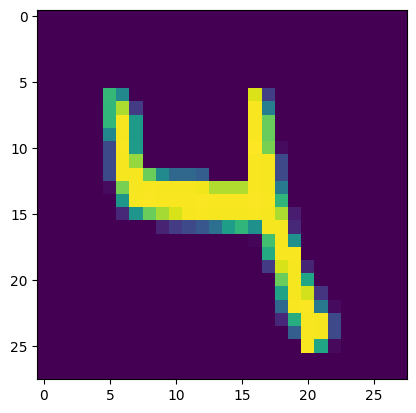

In [34]:
mnist_val = torch.load('../mnist-val.pth')
plt.imshow(mnist_val['X'][30].numpy()[0]), mnist_val['y'][30]


In [156]:
# weights = torch.load('/scratch/fk/R1/D2_100_9.pt')
weights = torch.load('/scratch/fk/R2/D3_1_4.pt')

weights.keys()

odict_keys(['conv1.0.weight', 'conv2.0.weight', 'conv3.0.weight', 'conv4.0.weight', 'fc.weight', 'fc.bias'])

In [157]:
model = CnnBaseModel()

CnnBaseModel created


In [161]:
model.load_state_dict(weights)
# model.fc.weight.data = torch.load('../fc-weight.pth')
# model.fc.bias.data = torch.load('../fc-bias.pth')

model

CnnBaseModel(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )
  (avg_pool): AvgPool2d(kernel_size=3, stride=3, padding=0)
  (fc): Linear(in_features=64, out_features=10, bias=True)
)

In [162]:
model = model.to('cuda')

In [163]:
data = torch.load('../mnist-val.pth')
model.eval()
with torch.no_grad():
    y_pred = model(data['X'].to('cuda')).detach()
    y_pred = torch.argmax(y_pred, dim=-1).cpu()
    acc = (y_pred == data['y']).sum()/len(data['y'])
    
acc

tensor(0.9688)

In [41]:
torch.save(weights['fc.weight'], './fc-weight.pth')
torch.save(weights['fc.bias'], './fc-bias.pth')


In [48]:
model.fc.weight.data = weights['fc.weight']

In [55]:
torch.load('../fc-weight.pth').shape

torch.Size([10, 64])

In [52]:
weights['fc.weight']

tensor([[ 4.8063e-02,  8.0907e-02,  1.1169e-01,  4.2856e-02, -1.6558e-01,
         -2.3325e-01,  1.2141e-01,  1.2295e-01, -9.1080e-02,  8.9980e-02,
          1.1595e-01,  9.2666e-02,  2.6229e-03,  1.4123e-02, -2.3828e-01,
          3.7252e-02, -1.0350e-02, -1.6447e-01, -7.8896e-02, -1.5520e-01,
         -3.9611e-02, -4.6294e-02,  1.3030e-01, -6.3744e-02, -1.0005e-02,
          1.4493e-02, -4.4470e-02, -1.0138e-01, -3.2088e-02, -3.4837e-02,
         -9.3678e-02, -7.8502e-02, -4.2883e-02,  7.3436e-02,  5.6863e-02,
         -1.1167e-01,  9.1519e-02,  8.8346e-02, -2.3059e-02, -9.2127e-02,
         -1.5051e-01,  2.9627e-02,  1.2830e-02, -4.7102e-02,  1.3332e-01,
         -2.9650e-02, -2.0953e-03,  2.8804e-02, -1.2145e-01, -1.0536e-01,
          1.3618e-02,  7.0084e-02,  6.6665e-02, -4.5854e-02,  1.0988e-01,
         -4.4875e-03,  1.4754e-01, -5.9641e-02,  2.6175e-02,  1.1111e-02,
         -9.6110e-02,  6.3570e-02,  6.0082e-03,  1.2782e-01],
        [-1.1196e-01, -2.2397e-01,  8.9427e-02,  1

In [60]:
model

CnnBaseModel(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )
  (avg_pool): AvgPool2d(kernel_size=3, stride=3, padding=0)
  (fc): Linear(in_features=64, out_features=10, bias=True)
)